In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
import logging

from models.cmiv_nn import regression_main, loss_func, prepro_args
from models.MerrorKIV.cmiv_k import *
from util import dotdict, fill_in_args, compute_rbf_kernel, cme_tuning, \
                make_psd, get_K, make_dotdict, fns
from general_util import get_median_inter_mnist


from models.MerrorKIV.trainer import get_median, MerrorKIVTrainer
from models.MerrorKIV.model import MerrorKIVModel
from data import generate_train_data, generate_test_data

from miv.data import merror_funcs
from miv.data.data_class import TrainDataSet, TestDataSet
# from 

In [2]:
def construct_NP(self): # Newey-Powell 'sigmoid' design
    NP_design = dotdict({
        'name': 'NP',
        'N_data': 10000,
        'noise_level': 2.,
        'noise_level_merror': 0.1,
        'merror_dim': 0,
        'bias': 0.
    })
    NP_design = dotdict(NP_design)

    NP_design.MU = np.zeros((3,))
    NP_design.SIGMA = np.array([[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]])

    NP_design.futw = lambda N_data: np.random.multivariate_normal(NP_design.MU, NP_design.SIGMA, size=N_data)
    NP_design.utw = NP_design.futw(NP_design.N_data)
    NP_design.fu = lambda N_data: NP_design.utw[:, 0].reshape(-1,1)
    NP_design.fz = lambda N_data: stats.norm.cdf(NP_design.utw[:, 2]).reshape(-1,1)
    NP_design.fx = lambda z, u, N_data: stats.norm.cdf((NP_design.utw[:, 1] + NP_design.utw[:, 2]) / np.sqrt(2)).reshape(-1,1)
    NP_design.fy = lambda x, u, N_data: np.log(np.abs(16 * x - 8) + 1) * np.sign(x - 0.5) + u
    NP_design.fm = lambda x, N_data: x + NP_design.noise_level_merror * np.random.normal(0, 1, N_data).reshape(-1,1)
    NP_design.fn = lambda x, N_data: x + NP_design.noise_level_merror * np.random.normal(0, 1, N_data).reshape(-1,1) + NP_design.bias
    NP_design.ydox = lambda x: np.log(np.abs(16 * x - 8) + 1) * np.sign(x - 0.5)
    data_NP = sim_dgp(NP_design)

    self.NP = dotdict({})
    self.NP.data = data_NP
    self.NP.design = NP_design

In [3]:
def sim_dgp(design):
    U = design.fu(design.N_data)  # e.g. socio-economic status
    Z = design.fz(design.N_data)  # whether they got a scholarship from some goverment studies - completely at random
    X = design.fx(Z, U, design.N_data)  # IQ/'ability'
    M = design.fm(X, design.N_data)
    N = design.fn(X, design.N_data)
    Y = design.fy(X, U, design.N_data)
    # breakpoint()
    data = dotdict({})
    data.X = X
    data.Y = Y
    data.Z = Z
    data.M = M
    data.N = N
    data.U = U
    return data



In [27]:
NP_design = dotdict({
    'name': 'NP',
    'N_data': 10000,
    'noise_level': 2.,
    'noise_level_merror': 0.5,
    'merror_dim': 0,
    'bias': 0.
})

NP_design = dotdict(NP_design)
NP_design.MU = np.zeros((3,))
NP_design.SIGMA = np.array([[1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]])

NP_design.futw = lambda N_data: np.random.multivariate_normal(NP_design.MU, NP_design.SIGMA, size=N_data)
NP_design.utw = NP_design.futw(NP_design.N_data)
NP_design.fu = lambda N_data: NP_design.utw[:, 0].reshape(-1,1)
NP_design.fz = lambda N_data: stats.norm.cdf(NP_design.utw[:, 2]).reshape(-1,1)
NP_design.fx = lambda z, u, N_data: stats.norm.cdf((NP_design.utw[:, 1] + NP_design.utw[:, 2]) / np.sqrt(2)).reshape(-1,1)
NP_design.fy = lambda x, u, N_data: np.log(np.abs(16 * x - 8) + 1) * np.sign(x - 0.5) + u
NP_design.fm = lambda x, N_data: x + NP_design.noise_level_merror * np.random.normal(0, 1, N_data).reshape(-1,1)
NP_design.fn = lambda x, N_data: x + NP_design.noise_level_merror * np.random.normal(0, 1, N_data).reshape(-1,1) + NP_design.bias
NP_design.ydox = lambda x: np.log(np.abs(16 * x - 8) + 1) * np.sign(x - 0.5)



In [26]:
np.std(X)

0.2883939583534514

In [8]:
U = NP_design.fu(NP_design.N_data)

U is latent.



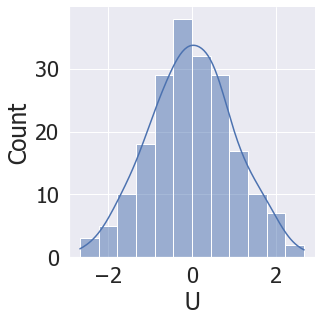

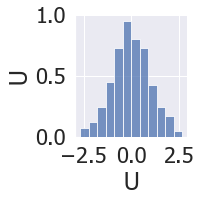

In [11]:
visualise_dataset(dotdict({'U': U}), sample_size=200, observed_keys=[])



In [12]:
Z = NP_design.fz(NP_design.N_data)

Z is latent.



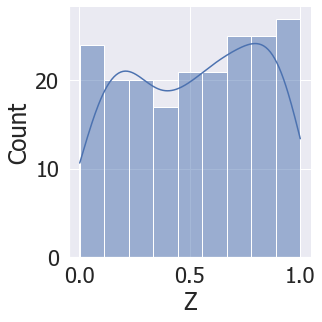

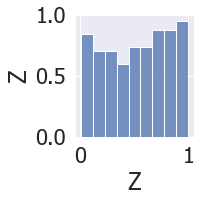

In [13]:
visualise_dataset(dotdict({'Z': Z}), sample_size=200, observed_keys=[])


In [14]:
X = NP_design.fx(Z, U, NP_design.N_data)

U is latent.

Z is latent.

X is latent.



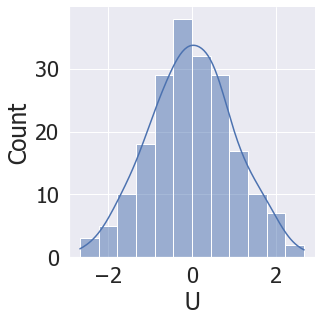

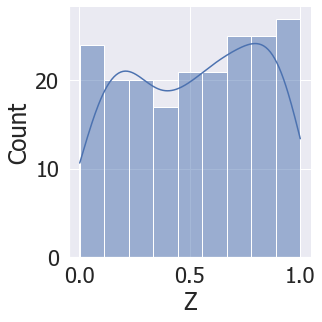

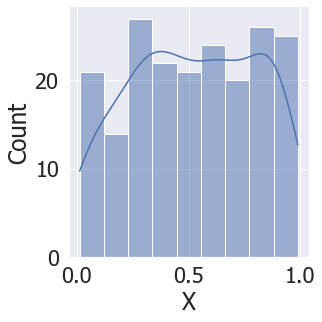

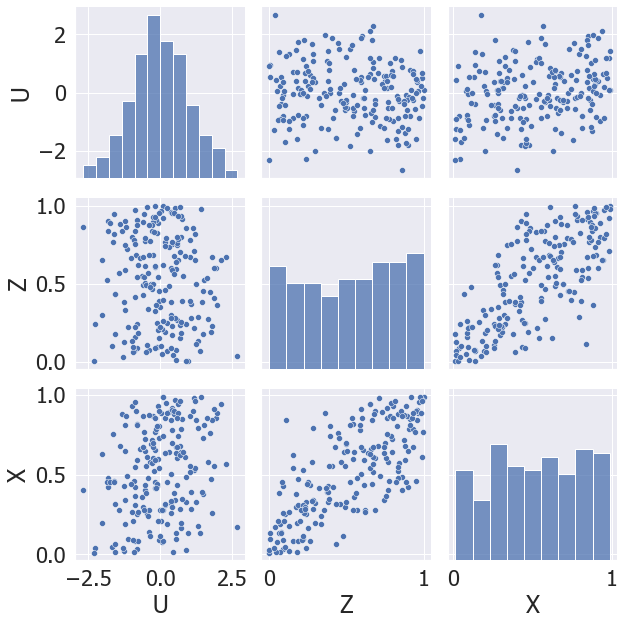

In [16]:
visualise_dataset(dotdict({'U': U, 'Z': Z, 'X': X}), sample_size=200, observed_keys=[])


X is latent.

M is latent.



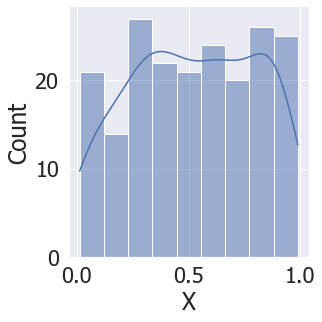

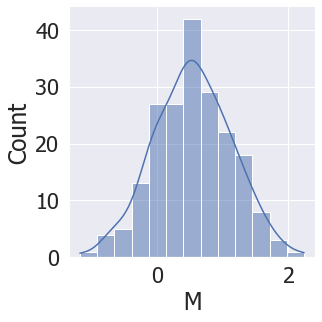

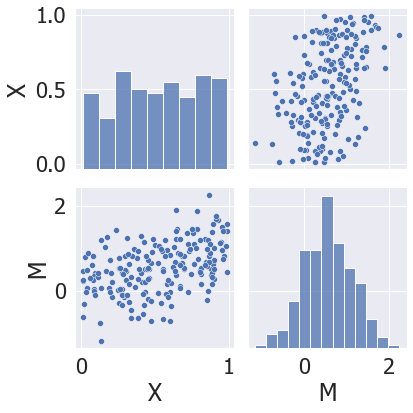

In [29]:
M = NP_design.fm(X, NP_design.N_data)
visualise_dataset(dotdict({'X': X, 'M': M}), sample_size=200, observed_keys=[])




X is latent.

M is latent.

N is latent.



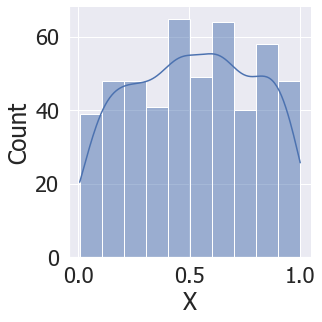

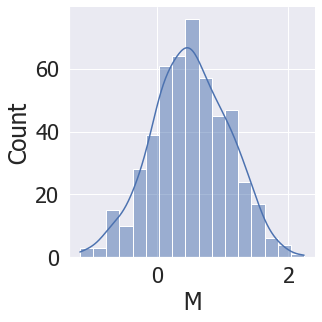

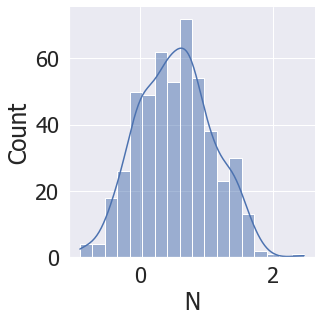

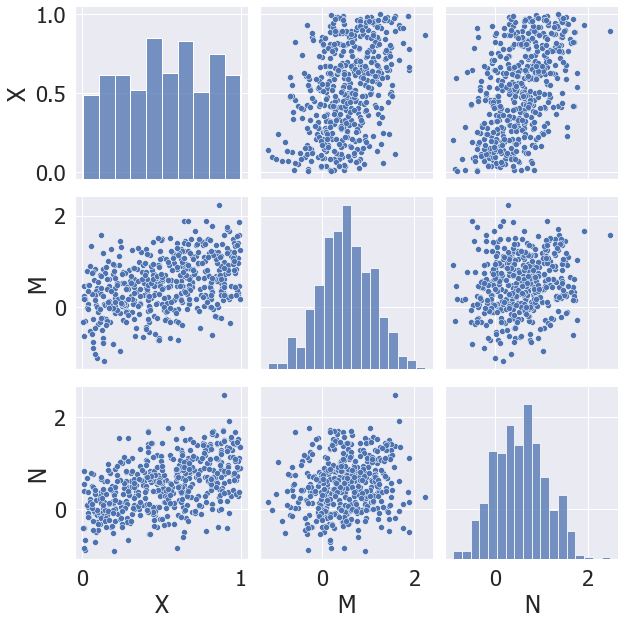

In [31]:
N = NP_design.fn(X, NP_design.N_data)
visualise_dataset(dotdict({'X': X, 'M': M, 'N': N}), sample_size=500, observed_keys=[])



X is latent.

U is latent.

Y is latent.



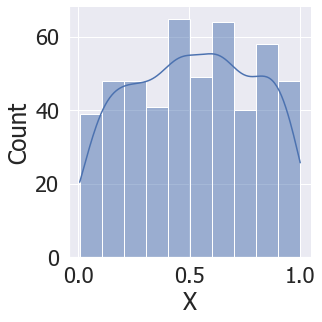

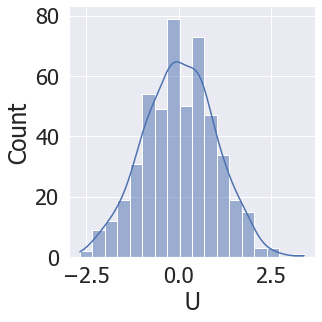

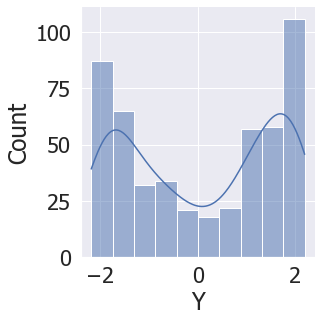

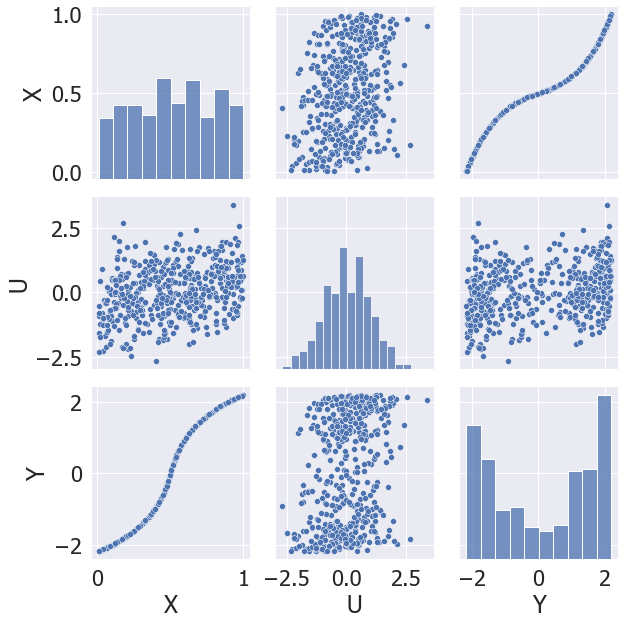

In [24]:
Y = NP_design.fy(X, U, NP_design.N_data)
visualise_dataset(dotdict({'X': X, 'U': U, 'Y': Y}), sample_size=500, observed_keys=[])
